# Packages

In [ ]:
import torch
import pandas as pd
import numpy as np
import random as rd
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sn
import sys
sys.path.append('..')
from Data import load_and_prepare_dataset_for_layoutLM
from transformers import LayoutLMForTokenClassification
from Training import fine_tune_model, evaluate_model
import torch.nn as nn
from torch.utils.data import DataLoader

from collections import Counter
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import math
import torch.nn.functional as F


from transformers import AdamW
import pickle
from transformers.optimization import AdamW
from transformers import get_linear_schedule_with_warmup
import math

from Training import fine_tune_model, evaluate_model
from Data import load_and_prepare_dataset_for_layoutLM

%load_ext autoreload
%autoreload 2       

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
id2label, label2id, train_dataloader, val_dataloader, test_dataloader = load_and_prepare_dataset_for_layoutLM(batch_size=2)

In [ ]:
class VeRALayer(nn.Module):
    def __init__(self, pretrained_layer, A_shared, B_shared, rank, d_init=1.0):
        super().__init__()
        self.rank = rank
        self.pretrained_layer = pretrained_layer
        self.A = A_shared
        self.B = B_shared
        dim_out, _ = B_shared.weight.shape

        # Initialize d and b
        d_weight = torch.zeros(self.rank)
        d_weight[rd.randint(0, self.rank - 1)] = d_init
        self.d = nn.Parameter(d_weight)
        self.b = nn.Parameter(torch.zeros(dim_out))


    def forward(self, x):
      # Compute output using the pretrained weights
      pretrained_out = self.pretrained_layer(x)

      # Compute the VeRA output
      a_forward = self.A(x) * self.d
      vera_out = self.B(a_forward) * self.b

      return pretrained_out + vera_out


In [ ]:

pretrained_layer = nn.Linear(in_features=4, out_features=4)
A_shared = nn.Linear(in_features=4, out_features=2)
B_shared = nn.Linear(in_features=2, out_features=4)

layer = VeRALayer(pretrained_layer=pretrained_layer, A_shared=A_shared, B_shared=B_shared, rank=2)

In [ ]:

test_input = torch.randn((1, 4))
res = layer(test_input)

In [ ]:

A_shared = nn.Linear(in_features=2, out_features=2)
print(A_shared.weight)
torch.nn.init.kaiming_normal_(A_shared.weight)
print('\n', A_shared.weight)

Parameter containing:
tensor([[ 0.6874,  0.4853],
        [-0.4767,  0.3044]], requires_grad=True)

 Parameter containing:
tensor([[1.7056, 0.3993],
        [1.6583, 2.1396]], requires_grad=True)


In [ ]:
model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased")

# Get the layer names
layer_names = [name for name, _ in model.named_modules()]

print(layer_names)

model.safetensors:   0%|          | 0.00/453M [00:00<?, ?B/s]

Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'layoutlm.embeddings.word_embeddings.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['', 'layoutlm', 'layoutlm.embeddings', 'layoutlm.embeddings.word_embeddings', 'layoutlm.embeddings.position_embeddings', 'layoutlm.embeddings.x_position_embeddings', 'layoutlm.embeddings.y_position_embeddings', 'layoutlm.embeddings.h_position_embeddings', 'layoutlm.embeddings.w_position_embeddings', 'layoutlm.embeddings.token_type_embeddings', 'layoutlm.embeddings.LayerNorm', 'layoutlm.embeddings.dropout', 'layoutlm.encoder', 'layoutlm.encoder.layer', 'layoutlm.encoder.layer.0', 'layoutlm.encoder.layer.0.attention', 'layoutlm.encoder.layer.0.attention.self', 'layoutlm.encoder.layer.0.attention.self.query', 'layoutlm.encoder.layer.0.attention.self.key', 'layoutlm.encoder.layer.0.attention.self.value', 'layoutlm.encoder.layer.0.attention.self.dropout', 'layoutlm.encoder.layer.0.attention.output', 'layoutlm.encoder.layer.0.attention.output.dense', 'layoutlm.encoder.layer.0.attention.output.LayerNorm', 'layoutlm.encoder.layer.0.attention.output.dropout', 'layoutlm.encoder.layer.0.intermed

In [ ]:

def apply_vera_to_layoutlm(model, rank):
    A_shared, B_shared = None, None
    vera_layers = {}

    # Freeze original weights
    for param in model.parameters():
        param.requires_grad = False

    # Create VeRA layers where needed
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear) and ('query' in name or 'key' in name):

            # Initialize shared A and B matrices if needed
            if A_shared is None:
                module_size = module.weight.shape[0]
                A_shared = nn.Linear(in_features=module_size, out_features=rank)
                torch.nn.init.kaiming_normal_(A_shared.weight)
                A_shared.requires_grad = False
                B_shared = nn.Linear(in_features=rank, out_features=module_size)
                torch.nn.init.kaiming_normal_(B_shared.weight)
                B_shared.requires_grad = False

            # Instanciate a VeRA layer
            vera_layer = VeRALayer(pretrained_layer=module, A_shared=A_shared, B_shared=B_shared, rank=rank)
            vera_layers[name] = vera_layer

    # Replace original Modules by VeRA modules
    for name, vera_module in vera_layers.items():
        parent_name, child_name = name.rsplit('.', 1)
        parent_module = dict(model.named_modules())[parent_name]
        setattr(parent_module, child_name, vera_module)

    # Ensure that the VeRA modules trainables parameters are trainables and the others are not
    for module in model.modules():
        if isinstance(module, VeRALayer):
            for name, param in module.named_parameters():
                if name not in ['b', 'd']:
                    param.requires_grad = False
    for name, param in model.named_parameters():
        if name.startswith('classifier'):
            param.requires_grad = True
    return model

In [ ]:
model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=len(id2label), id2label=id2label, label2id=label2id)
model = apply_vera_to_layoutlm(model, 16)

Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [69]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Utiliser la fonction pour obtenir le nombre de paramètres entraînables du modèle VeRA
trainable_params = count_parameters(model)
print("Nombre de paramètres entraînables du modèle VeRA :", trainable_params)


Nombre de paramètres entraînables du modèle VeRA : 23839


In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")

Trainable: layoutlm.encoder.layer.0.attention.self.query.d
Trainable: layoutlm.encoder.layer.0.attention.self.query.b
Trainable: layoutlm.encoder.layer.0.attention.self.key.d
Trainable: layoutlm.encoder.layer.0.attention.self.key.b
Trainable: layoutlm.encoder.layer.1.attention.self.query.d
Trainable: layoutlm.encoder.layer.1.attention.self.query.b
Trainable: layoutlm.encoder.layer.1.attention.self.key.d
Trainable: layoutlm.encoder.layer.1.attention.self.key.b
Trainable: layoutlm.encoder.layer.2.attention.self.query.d
Trainable: layoutlm.encoder.layer.2.attention.self.query.b
Trainable: layoutlm.encoder.layer.2.attention.self.key.d
Trainable: layoutlm.encoder.layer.2.attention.self.key.b
Trainable: layoutlm.encoder.layer.3.attention.self.query.d
Trainable: layoutlm.encoder.layer.3.attention.self.query.b
Trainable: layoutlm.encoder.layer.3.attention.self.key.d
Trainable: layoutlm.encoder.layer.3.attention.self.key.b
Trainable: layoutlm.encoder.layer.4.attention.self.query.d
Trainable: la

## Finetuning

In [ ]:


r_values = [16]
# NOTE: 'We then scale ∆W x by α/r, where α is a constant in r' (from the paper)

NUM_EXPERIMENTS = 1
results_list = []

for _ in range(NUM_EXPERIMENTS):
    # Store results, losses and metrics for each model
    results_dict = {}
    for r in r_values:

        training_losses_list, val_losses_list, training_f1s_list, val_f1s_list, training_accs_list, val_accs_list = [], [], [], [], [], []

        print("######## Training with r={}  ########".format(r))
        # Configure model
        model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=len(id2label), id2label=id2label, label2id=label2id)
        model = apply_vera_to_layoutlm(model, r)

        optimizer = AdamW(params=model.parameters(),
                        lr=5e-3, weight_decay=0.01)
        scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=2, num_training_steps=30)

        training_losses, val_losses, training_f1s, val_f1s, training_accs, val_accs = fine_tune_model(
            model=model,
            device=device,
            optimizer=optimizer,
            scheduler=scheduler,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            id2label=id2label,
            num_epoch_max=20,
            early_stopping=False,
            test_frequency=1,
            model_folder='Vera_Fine_Tuning',
            model_name=f'Vera_r_{r}'
        )
        training_losses_list.append(training_losses)
        val_losses_list.append(val_losses)
        training_f1s_list.append(training_f1s)
        val_f1s_list.append(val_f1s)
        training_accs_list.append(training_accs)
        val_accs_list.append(val_accs)

        results = evaluate_model(
            model=model,
            device=device,
            test_dataloader=test_dataloader,
            original_id2label=id2label
        )

        results['training_losses_list'] =  training_losses_list
        results['val_losses_list'] =  val_losses_list
        results['training_f1s_list'] =  training_f1s_list
        results['val_f1s_list'] =  val_f1s_list
        results['training_accs_list'] =  training_accs_list
        results['val_accs_list'] =  val_accs_list

        results_dict[r] = results
        print('\n')

    results_list.append(results_dict)
    with open('results_list_vera.pkl', 'wb') as f:
        pickle.dump(results_list, f)

######## Training with r=16  ########


model.safetensors:   0%|          | 0.00/451M [00:00<?, ?B/s]

Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting Training
Epoch: 1/20


Training: 100%|██████████| 75/75 [00:10<00:00,  7.16it/s]


Epoch Training loss: 1.0082834919293722, Training F1 Score: 0.3085398010599692, Training Accuracy: 0.29381930286907665


Test: 100%|██████████| 13/13 [00:00<00:00, 15.61it/s]


Epoch Test loss: 1.005914541391226, Test F1 Score: 0.3271077908217716, Test Accuracy: 0.2985874330248417
Epoch: 2/20


Training: 100%|██████████| 75/75 [00:10<00:00,  7.17it/s]


Epoch Training loss: 0.667430036465327, Training F1 Score: 0.6221721826560536, Training Accuracy: 0.59405


Test: 100%|██████████| 13/13 [00:00<00:00, 15.37it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch Test loss: 0.5412296790343064, Test F1 Score: 0.6793190064192018, Test Accuracy: 0.6445974576271186
Epoch: 3/20


Training: 100%|██████████| 75/75 [00:10<00:00,  7.13it/s]


Epoch Training loss: 0.48426307280858355, Training F1 Score: 0.744558310575129, Training Accuracy: 0.7326911819488052


Test: 100%|██████████| 13/13 [00:00<00:00, 15.33it/s]


Epoch Test loss: 0.43542073323176456, Test F1 Score: 0.7353719494266392, Test Accuracy: 0.7330011723329426
Epoch: 4/20


Training: 100%|██████████| 75/75 [00:10<00:00,  7.11it/s]


Epoch Training loss: 0.4014862048625946, Training F1 Score: 0.7908411822020137, Training Accuracy: 0.7789507357645553


Test: 100%|██████████| 13/13 [00:00<00:00, 14.32it/s]


Epoch Test loss: 0.4095836247389133, Test F1 Score: 0.7403424366775152, Test Accuracy: 0.7114495512646178
Epoch: 5/20


Training: 100%|██████████| 75/75 [00:10<00:00,  7.09it/s]


Epoch Training loss: 0.363834414879481, Training F1 Score: 0.8090595551693234, Training Accuracy: 0.7995276689388653


Test: 100%|██████████| 13/13 [00:00<00:00, 15.20it/s]


Epoch Test loss: 0.37164621628247774, Test F1 Score: 0.7655388284394099, Test Accuracy: 0.7737270262127147
Epoch: 6/20


Training: 100%|██████████| 75/75 [00:10<00:00,  7.07it/s]


Epoch Training loss: 0.33378945231437684, Training F1 Score: 0.8216826896963773, Training Accuracy: 0.8120236178207193


Test: 100%|██████████| 13/13 [00:00<00:00, 15.23it/s]


Epoch Test loss: 0.36248499842790455, Test F1 Score: 0.7846752124441885, Test Accuracy: 0.7666760484097945
Epoch: 7/20


Training: 100%|██████████| 75/75 [00:10<00:00,  7.05it/s]


Epoch Training loss: 0.30766190081834793, Training F1 Score: 0.8344284195316121, Training Accuracy: 0.8277708660139558


Test: 100%|██████████| 13/13 [00:00<00:00, 15.24it/s]


Epoch Test loss: 0.3885661168740346, Test F1 Score: 0.7632126508531002, Test Accuracy: 0.7203456402199528
Epoch: 8/20


Training: 100%|██████████| 75/75 [00:10<00:00,  7.02it/s]


Epoch Training loss: 0.28795264611641563, Training F1 Score: 0.8471651378643948, Training Accuracy: 0.8390575295195989


Test: 100%|██████████| 13/13 [00:00<00:00, 15.12it/s]


Epoch Test loss: 0.35539473363986385, Test F1 Score: 0.7845368344274253, Test Accuracy: 0.7760461760461761
Epoch: 9/20


Training: 100%|██████████| 75/75 [00:10<00:00,  7.00it/s]


Epoch Training loss: 0.27504023353258766, Training F1 Score: 0.8549664009576406, Training Accuracy: 0.8463775922434689


Test: 100%|██████████| 13/13 [00:00<00:00, 15.18it/s]


Epoch Test loss: 0.3608751285534639, Test F1 Score: 0.7781763826606876, Test Accuracy: 0.7887878787878788
Epoch: 10/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.99it/s]


Epoch Training loss: 0.2647759583592415, Training F1 Score: 0.8617642245376683, Training Accuracy: 0.8552788305360043


Test: 100%|██████████| 13/13 [00:00<00:00, 15.15it/s]


Epoch Test loss: 0.35820262363323796, Test F1 Score: 0.7806669604818569, Test Accuracy: 0.7775826748609892
Epoch: 11/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.98it/s]


Epoch Training loss: 0.24710475862026215, Training F1 Score: 0.8711937409699315, Training Accuracy: 0.8641501270888541


Test: 100%|██████████| 13/13 [00:00<00:00, 15.19it/s]


Epoch Test loss: 0.34709083231595844, Test F1 Score: 0.7936975408629069, Test Accuracy: 0.7924139958835636
Epoch: 12/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.96it/s]


Epoch Training loss: 0.2330603678027789, Training F1 Score: 0.8733796422906526, Training Accuracy: 0.869054098182214


Test: 100%|██████████| 13/13 [00:00<00:00, 15.11it/s]


Epoch Test loss: 0.36382168531417847, Test F1 Score: 0.7833211411850768, Test Accuracy: 0.7770682148040639
Epoch: 13/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.95it/s]


Epoch Training loss: 0.22968508332967758, Training F1 Score: 0.8779674907799481, Training Accuracy: 0.8726986368326726


Test: 100%|██████████| 13/13 [00:00<00:00, 14.95it/s]


Epoch Test loss: 0.35768274045907533, Test F1 Score: 0.7889119478209309, Test Accuracy: 0.7929082240762813
Epoch: 14/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.94it/s]


Epoch Training loss: 0.2258846241235733, Training F1 Score: 0.8811732195135298, Training Accuracy: 0.8772130522416517


Test: 100%|██████████| 13/13 [00:00<00:00, 13.67it/s]


Epoch Test loss: 0.35985835469686067, Test F1 Score: 0.7883338146116085, Test Accuracy: 0.7720588235294118
Epoch: 15/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.94it/s]


Epoch Training loss: 0.21827294210592907, Training F1 Score: 0.8891558370645408, Training Accuracy: 0.883271859405511


Test: 100%|██████████| 13/13 [00:00<00:00, 14.11it/s]


Epoch Test loss: 0.35652415454387665, Test F1 Score: 0.793193717277487, Test Accuracy: 0.7822719449225474
Epoch: 16/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.94it/s]


Epoch Training loss: 0.21340616663297018, Training F1 Score: 0.8887311640096089, Training Accuracy: 0.8827548806941432


Test: 100%|██████████| 13/13 [00:00<00:00, 14.99it/s]


Epoch Test loss: 0.3537016866298822, Test F1 Score: 0.7895284843076007, Test Accuracy: 0.7962796279627963
Epoch: 17/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.93it/s]


Epoch Training loss: 0.20837813685337703, Training F1 Score: 0.8891200218968113, Training Accuracy: 0.8854603936106417


Test: 100%|██████████| 13/13 [00:00<00:00, 14.98it/s]


Epoch Test loss: 0.3544321610377385, Test F1 Score: 0.7909939268256555, Test Accuracy: 0.7944064266587325
Epoch: 18/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.92it/s]


Epoch Training loss: 0.19786345412333806, Training F1 Score: 0.8940841523173367, Training Accuracy: 0.8905491628946938


Test: 100%|██████████| 13/13 [00:00<00:00, 15.03it/s]


Epoch Test loss: 0.35432441532611847, Test F1 Score: 0.7959895379250218, Test Accuracy: 0.7843642611683849
Epoch: 19/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.90it/s]


Epoch Training loss: 0.19653048584858576, Training F1 Score: 0.8957838722881701, Training Accuracy: 0.8894488701024224


Test: 100%|██████████| 13/13 [00:00<00:00, 14.90it/s]


Epoch Test loss: 0.34856626047537875, Test F1 Score: 0.7919976463665783, Test Accuracy: 0.789906103286385
Epoch: 20/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.85it/s]


Epoch Training loss: 0.19591124127308526, Training F1 Score: 0.896710274235043, Training Accuracy: 0.8929466913768669


Test: 100%|██████████| 13/13 [00:00<00:00, 14.74it/s]


Epoch Test loss: 0.3472975767575778, Test F1 Score: 0.7958853783982365, Test Accuracy: 0.7929721815519766


Time elapsed,▁▁▃█▂▂▂▂▂▂▂▂▂▆▇▂▂▃▃▄
it_s,██▆▁▇▇▇▇▇▇▇▆▆▃▂▆▇▆▆▅
Time elapsed,12.37402
it_s,0.16163
memory_GB,1.5889


Training finished.


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 11.01it/s]


In [ ]:
results_list_vera = []

for fname in os.listdir():
    if fname.startswith('results_list_vera'):
        with open(fname, 'rb') as f:
            results_list_vera.extend(pickle.load(f))

In [ ]:
result_dict = {}

for d in results_list_vera:
    for key, value in d.items():
        result_dict.setdefault(key, []).append(value)



In [ ]:

NUM_EXPERIMENTS = len(results_list_vera)

def aggregate_line_results(metric_list, num_experiments = NUM_EXPERIMENTS):

    max_length = max(len(sublist) for sublist in metric_list)

    x_values = np.linspace(1, max_length, max_length)
    results = np.array([sublist + [np.nan] * (max_length - len(sublist)) for sublist in metric_list])

    # Calculate mean and standard deviation for each x-value
    mean_curve = np.mean(results, axis=0)
    std_curve = np.std(results, axis=0, ddof=1)  # ddof=1 for sample standard deviation

    # Calculate confidence interval at 90% level
    confidence_interval_upper = mean_curve + 1.96 * std_curve / np.sqrt(num_experiments)
    confidence_interval_lower = mean_curve - 1.96 * std_curve / np.sqrt(num_experiments)

    return x_values, mean_curve, confidence_interval_lower, confidence_interval_upper


def plot_line_results(ax: plt.Axes, plot_data_and_kwargs, fill_between = True):
    """
    plot_data_and_kwargs: List of tuples.
        Each tuple being of the form (x_values, mean_curve, conf_interval_lower, conf_interval_upper, label)
    """

    for tuple_data_and_kwargs in plot_data_and_kwargs:
        x_values, mean_curve, confidence_interval_lower, confidence_interval_upper, label = tuple_data_and_kwargs

        # Plot the first mean curve
        ax.plot(x_values, mean_curve, label=label)

        # Plot the confidence interval as a shaded region
        if fill_between:
            ax.fill_between(x_values, confidence_interval_lower, confidence_interval_upper, alpha=0.3)

    ax.legend()

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


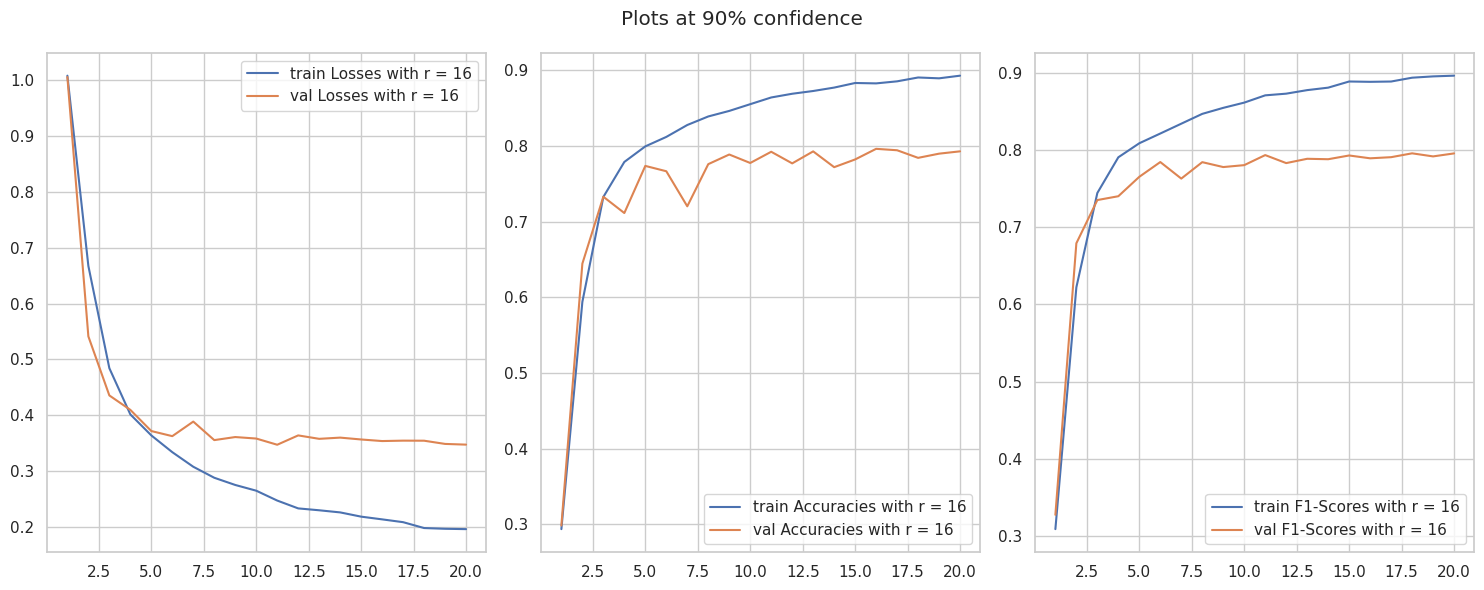

In [ ]:
################################   CLASSIFIER LAYER: trainable  _  r=16  _ lr=5e-3  _  weight_decay=0.01    ###################################################





sn.set(style="whitegrid")
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

plot_data_and_kwargs_loss = []
plot_data_and_kwargs_accs = []
plot_data_and_kwargs_f1s = []

for key in result_dict.keys():

    train_losses_list = [result_dict[key][i]['training_losses_list'][0] for i in range(len(result_dict[key]))]
    train_accs_list = [result_dict[key][i]['training_accs_list'][0] for i in range(len(result_dict[key]))]
    train_f1s_list = [result_dict[key][i]['training_f1s_list'][0] for i in range(len(result_dict[key]))]

    val_losses_list = [result_dict[key][i]['val_losses_list'][0] for i in range(len(result_dict[key]))]
    val_accs_list = [result_dict[key][i]['val_accs_list'][0] for i in range(len(result_dict[key]))]
    val_f1s_list = [result_dict[key][i]['val_f1s_list'][0] for i in range(len(result_dict[key]))]

    # Loss plot
    x_values_loss, mean_curve_loss, ci_lower_loss, ci_upper_loss = aggregate_line_results(train_losses_list)
    plot_data_and_kwargs_loss.append((x_values_loss, mean_curve_loss, ci_lower_loss, ci_upper_loss, f'train Losses with r = {key}'))
    x_values_loss, mean_curve_loss, ci_lower_loss, ci_upper_loss = aggregate_line_results(val_losses_list)
    plot_data_and_kwargs_loss.append((x_values_loss, mean_curve_loss, ci_lower_loss, ci_upper_loss, f'val Losses with r = {key}'))

    # Accuracy plot
    x_values_accs, mean_curve_accs, ci_lower_accs, ci_upper_accs = aggregate_line_results(train_accs_list)
    plot_data_and_kwargs_accs.append((x_values_accs, mean_curve_accs, ci_lower_accs, ci_upper_accs, f'train Accuracies with r = {key}'))
    x_values_accs, mean_curve_accs, ci_lower_accs, ci_upper_accs = aggregate_line_results(val_accs_list)
    plot_data_and_kwargs_accs.append((x_values_accs, mean_curve_accs, ci_lower_accs, ci_upper_accs, f'val Accuracies with r = {key}'))

    # F1-score plot
    x_values_f1s, mean_curve_f1s, ci_lower_f1s, ci_upper_f1s = aggregate_line_results(train_f1s_list)
    plot_data_and_kwargs_f1s.append((x_values_f1s, mean_curve_f1s, ci_lower_f1s, ci_upper_f1s, f'train F1-Scores with r = {key}'))
    x_values_f1s, mean_curve_f1s, ci_lower_f1s, ci_upper_f1s = aggregate_line_results(val_f1s_list)
    plot_data_and_kwargs_f1s.append((x_values_f1s, mean_curve_f1s, ci_lower_f1s, ci_upper_f1s, f'val F1-Scores with r = {key}'))


plot_line_results(axs[0], plot_data_and_kwargs_loss)
plot_line_results(axs[1], plot_data_and_kwargs_accs)
plot_line_results(axs[2], plot_data_and_kwargs_f1s)

fig.suptitle('Plots at 90% confidence')

plt.tight_layout()
plt.show()

<Axes: >

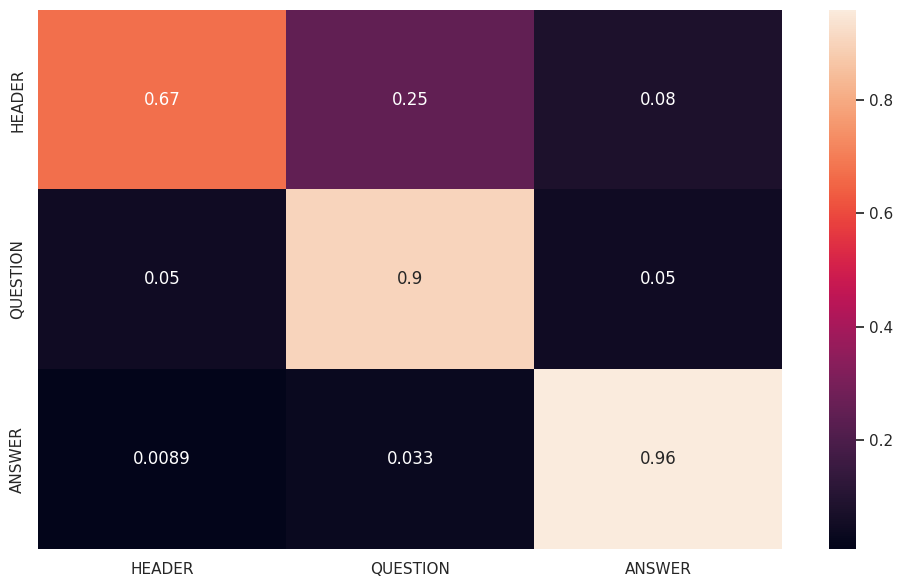

In [ ]:
plt.figure(figsize = (12,7))
sn.heatmap(result_dict[16][0]['conf_matrix_words'], annot=True)

##  test with different r values

In [ ]:


r_values = [4,8,16,32,64]
# NOTE: 'We then scale ∆W x by α/r, where α is a constant in r' (from the paper)

NUM_EXPERIMENTS = 1
results_list = []

for _ in range(NUM_EXPERIMENTS):
    # Store results, losses and metrics for each model
    results_dict = {}
    for r in r_values:

        training_losses_list, val_losses_list, training_f1s_list, val_f1s_list, training_accs_list, val_accs_list = [], [], [], [], [], []

        print("######## Training with r={}  ########".format(r))
        # Configure model
        model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=len(id2label), id2label=id2label, label2id=label2id)
        model = apply_vera_to_layoutlm(model, r)

        optimizer = AdamW(params=model.parameters(),
                        lr=5e-3, weight_decay=0.01)
        scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=2, num_training_steps=30)

        training_losses, val_losses, training_f1s, val_f1s, training_accs, val_accs = fine_tune_model(
            model=model,
            device=device,
            optimizer=optimizer,
            scheduler=scheduler,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            id2label=id2label,
            num_epoch_max=20,
            early_stopping=False,
            test_frequency=1,
            model_folder='Vera_Fine_Tuning',
            model_name=f'Vera_r_{r}'
        )
        training_losses_list.append(training_losses)
        val_losses_list.append(val_losses)
        training_f1s_list.append(training_f1s)
        val_f1s_list.append(val_f1s)
        training_accs_list.append(training_accs)
        val_accs_list.append(val_accs)

        results = evaluate_model(
            model=model,
            device=device,
            test_dataloader=test_dataloader,
            original_id2label=id2label
        )

        results['training_losses_list'] =  training_losses_list
        results['val_losses_list'] =  val_losses_list
        results['training_f1s_list'] =  training_f1s_list
        results['val_f1s_list'] =  val_f1s_list
        results['training_accs_list'] =  training_accs_list
        results['val_accs_list'] =  val_accs_list

        results_dict[r] = results
        print('\n')

    results_list.append(results_dict)
    with open('results_list_vera.pkl', 'wb') as f:
        pickle.dump(results_list, f)

######## Training with r=4  ########


Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting Training
Epoch: 1/20


Training: 100%|██████████| 75/75 [00:11<00:00,  6.73it/s]


Epoch Training loss: 0.9804644989967346, Training F1 Score: 0.40840511615766123, Training Accuracy: 0.3888557510686947


Test: 100%|██████████| 13/13 [00:00<00:00, 13.95it/s]


Epoch Test loss: 0.9830998778343201, Test F1 Score: 0.3872879073525451, Test Accuracy: 0.3562933597621407
Epoch: 2/20


Training: 100%|██████████| 75/75 [00:11<00:00,  6.74it/s]


Epoch Training loss: 0.6523489884535472, Training F1 Score: 0.6443547541671035, Training Accuracy: 0.6157583650571028


Test: 100%|██████████| 13/13 [00:00<00:00, 15.64it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch Test loss: 0.5277693111162919, Test F1 Score: 0.687862869781587, Test Accuracy: 0.6472424557752341
Epoch: 3/20


Training: 100%|██████████| 75/75 [00:10<00:00,  7.15it/s]


Epoch Training loss: 0.4775061051050822, Training F1 Score: 0.7519535970353661, Training Accuracy: 0.7350763899826744


Test: 100%|██████████| 13/13 [00:00<00:00, 15.57it/s]


Epoch Test loss: 0.4274179224784558, Test F1 Score: 0.736212430697403, Test Accuracy: 0.7283487297921478
Epoch: 4/20


Training: 100%|██████████| 75/75 [00:10<00:00,  7.12it/s]


Epoch Training loss: 0.39609028538068136, Training F1 Score: 0.7958078318799762, Training Accuracy: 0.7842959325290915


Test: 100%|██████████| 13/13 [00:00<00:00, 15.46it/s]


Epoch Test loss: 0.46037085010455203, Test F1 Score: 0.7065390749601276, Test Accuracy: 0.7690972222222222
Epoch: 5/20


Training: 100%|██████████| 75/75 [00:10<00:00,  7.10it/s]


Epoch Training loss: 0.37453329185644785, Training F1 Score: 0.8056054421768707, Training Accuracy: 0.7976613859252074


Test: 100%|██████████| 13/13 [00:00<00:00, 15.34it/s]


Epoch Test loss: 0.3857143200360812, Test F1 Score: 0.7638830012717253, Test Accuracy: 0.7331163547599675
Epoch: 6/20


Training: 100%|██████████| 75/75 [00:10<00:00,  7.07it/s]


Epoch Training loss: 0.3292972942193349, Training F1 Score: 0.8254984402549843, Training Accuracy: 0.8148663846195041


Test: 100%|██████████| 13/13 [00:00<00:00, 15.35it/s]


Epoch Test loss: 0.37708356976509094, Test F1 Score: 0.7557984931304477, Test Accuracy: 0.7570287067179639
Epoch: 7/20


Training: 100%|██████████| 75/75 [00:10<00:00,  7.07it/s]


Epoch Training loss: 0.3185241170724233, Training F1 Score: 0.8379139661443379, Training Accuracy: 0.8337414965986395


Test: 100%|██████████| 13/13 [00:00<00:00, 15.22it/s]


Epoch Test loss: 0.3710515900300099, Test F1 Score: 0.7712849964106245, Test Accuracy: 0.7513286713286713
Epoch: 8/20


Training: 100%|██████████| 75/75 [00:10<00:00,  7.04it/s]


Epoch Training loss: 0.2899477883179982, Training F1 Score: 0.8507474879503308, Training Accuracy: 0.8429658410231504


Test: 100%|██████████| 13/13 [00:00<00:00, 15.21it/s]


Epoch Test loss: 0.39248076195900256, Test F1 Score: 0.7567971317597848, Test Accuracy: 0.7666464891041163
Epoch: 9/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.90it/s]


Epoch Training loss: 0.2796256874005, Training F1 Score: 0.8572988317501911, Training Accuracy: 0.8514422034265886


Test: 100%|██████████| 13/13 [00:00<00:00, 15.16it/s]


Epoch Test loss: 0.3675456585792395, Test F1 Score: 0.7755340942347088, Test Accuracy: 0.7694541231126597
Epoch: 10/20


Training: 100%|██████████| 75/75 [00:10<00:00,  7.00it/s]


Epoch Training loss: 0.26968436539173124, Training F1 Score: 0.8609546722073378, Training Accuracy: 0.856412487762428


Test: 100%|██████████| 13/13 [00:00<00:00, 15.21it/s]


Epoch Test loss: 0.38059694033402663, Test F1 Score: 0.7659885848090152, Test Accuracy: 0.7600929422015684
Epoch: 11/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.99it/s]


Epoch Training loss: 0.25554497083028155, Training F1 Score: 0.8680283224400871, Training Accuracy: 0.8601575993091537


Test: 100%|██████████| 13/13 [00:00<00:00, 15.28it/s]


Epoch Test loss: 0.3697118965479044, Test F1 Score: 0.7650075414781297, Test Accuracy: 0.782716049382716
Epoch: 12/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.98it/s]


Epoch Training loss: 0.2472241461277008, Training F1 Score: 0.8733488308491728, Training Accuracy: 0.8690469710988952


Test: 100%|██████████| 13/13 [00:00<00:00, 15.18it/s]


Epoch Test loss: 0.363337075481048, Test F1 Score: 0.7720364741641338, Test Accuracy: 0.7578857630008525
Epoch: 13/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.97it/s]


Epoch Training loss: 0.24243121802806855, Training F1 Score: 0.8763546798029557, Training Accuracy: 0.8726291693917593


Test: 100%|██████████| 13/13 [00:00<00:00, 15.10it/s]


Epoch Test loss: 0.3840975979199776, Test F1 Score: 0.7633521493703864, Test Accuracy: 0.7493606138107417
Epoch: 14/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.96it/s]


Epoch Training loss: 0.23324354072411854, Training F1 Score: 0.8795974732697094, Training Accuracy: 0.8751700495184198


Test: 100%|██████████| 13/13 [00:00<00:00, 15.10it/s]


Epoch Test loss: 0.3685474395751953, Test F1 Score: 0.7810787424286126, Test Accuracy: 0.7641083521444695
Epoch: 15/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.95it/s]


Epoch Training loss: 0.22386047035455703, Training F1 Score: 0.8831452692549384, Training Accuracy: 0.87794013797599


Test: 100%|██████████| 13/13 [00:00<00:00, 15.05it/s]


Epoch Test loss: 0.3679110499528738, Test F1 Score: 0.7770210245780278, Test Accuracy: 0.7800237812128419
Epoch: 16/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.94it/s]


Epoch Training loss: 0.21984823952118557, Training F1 Score: 0.8838085873484104, Training Accuracy: 0.8783387622149837


Test: 100%|██████████| 13/13 [00:00<00:00, 15.05it/s]


Epoch Test loss: 0.3889547964701286, Test F1 Score: 0.7667402501839587, Test Accuracy: 0.7650513950073421
Epoch: 17/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.86it/s]


Epoch Training loss: 0.21871004899342855, Training F1 Score: 0.8864165730414052, Training Accuracy: 0.8837768427954756


Test: 100%|██████████| 13/13 [00:00<00:00, 15.00it/s]


Epoch Test loss: 0.38005997469791997, Test F1 Score: 0.767962308598351, Test Accuracy: 0.7666078777189889
Epoch: 18/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.93it/s]


Epoch Training loss: 0.2136674189567566, Training F1 Score: 0.88711266834556, Training Accuracy: 0.8835332606324973


Test: 100%|██████████| 13/13 [00:00<00:00, 14.89it/s]


Epoch Test loss: 0.36728612849345577, Test F1 Score: 0.7863197895352237, Test Accuracy: 0.7792584009269988
Epoch: 19/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.92it/s]


Epoch Training loss: 0.21075914561748504, Training F1 Score: 0.8901216013116545, Training Accuracy: 0.8850187469434332


Test: 100%|██████████| 13/13 [00:00<00:00, 15.01it/s]


Epoch Test loss: 0.37369606701227337, Test F1 Score: 0.7770626097132827, Test Accuracy: 0.7707486941381312
Epoch: 20/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.92it/s]


Epoch Training loss: 0.2098295909166336, Training F1 Score: 0.8910095154763207, Training Accuracy: 0.8864526659412405


Test: 100%|██████████| 13/13 [00:00<00:00, 14.94it/s]


Epoch Test loss: 0.37620123533102184, Test F1 Score: 0.7775504238526746, Test Accuracy: 0.7705677867902665


Time elapsed,█▃▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂
it_s,▁▆██████▇▇▇▇▇▇▇▇▇▇▇▇
Time elapsed,12.22928
it_s,0.16354
memory_GB,1.5879


Training finished.


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  9.44it/s]




######## Training with r=8  ########


Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting Training
Epoch: 1/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.93it/s]


Epoch Training loss: 0.9786923511823018, Training F1 Score: 0.23606265818455438, Training Accuracy: 0.31242078580481625


Test: 100%|██████████| 13/13 [00:00<00:00, 15.02it/s]


Epoch Test loss: 0.973503956427941, Test F1 Score: 0.19480276687231257, Test Accuracy: 0.2659520163348647
Epoch: 2/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.96it/s]


Epoch Training loss: 0.6593127183119456, Training F1 Score: 0.6512823202391567, Training Accuracy: 0.6227058469561729


Test: 100%|██████████| 13/13 [00:00<00:00, 15.12it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch Test loss: 0.5356053068087652, Test F1 Score: 0.6860612907781386, Test Accuracy: 0.6580872392305608
Epoch: 3/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.95it/s]


Epoch Training loss: 0.4836344524224599, Training F1 Score: 0.7475728155339806, Training Accuracy: 0.7337992376111817


Test: 100%|██████████| 13/13 [00:00<00:00, 15.19it/s]


Epoch Test loss: 0.4324536392321953, Test F1 Score: 0.7515349979533361, Test Accuracy: 0.6991622239146992
Epoch: 4/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.86it/s]


Epoch Training loss: 0.4090415330727895, Training F1 Score: 0.7875675675675676, Training Accuracy: 0.7746703530412591


Test: 100%|██████████| 13/13 [00:00<00:00, 15.01it/s]


Epoch Test loss: 0.40259254093353564, Test F1 Score: 0.7491638795986622, Test Accuracy: 0.7728983688833124
Epoch: 5/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.94it/s]


Epoch Training loss: 0.3765002971887588, Training F1 Score: 0.8068076776684246, Training Accuracy: 0.7981710597095213


Test: 100%|██████████| 13/13 [00:00<00:00, 14.99it/s]


Epoch Test loss: 0.37062469812539905, Test F1 Score: 0.7732990280160092, Test Accuracy: 0.7501386577925679
Epoch: 6/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.92it/s]


Epoch Training loss: 0.33833542943000794, Training F1 Score: 0.8256895663258387, Training Accuracy: 0.8149258525617004


Test: 100%|██████████| 13/13 [00:00<00:00, 15.05it/s]


Epoch Test loss: 0.3539777913918862, Test F1 Score: 0.7770210245780278, Test Accuracy: 0.7800237812128419
Epoch: 7/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.93it/s]


Epoch Training loss: 0.31354387521743776, Training F1 Score: 0.838107603667938, Training Accuracy: 0.8250519252276721


Test: 100%|██████████| 13/13 [00:00<00:00, 14.95it/s]


Epoch Test loss: 0.35547612607479095, Test F1 Score: 0.7857142857142857, Test Accuracy: 0.8140417457305503
Epoch: 8/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.92it/s]


Epoch Training loss: 0.29852449337641396, Training F1 Score: 0.8449987691802741, Training Accuracy: 0.8409276498448472


Test: 100%|██████████| 13/13 [00:00<00:00, 14.91it/s]


Epoch Test loss: 0.3621245806033795, Test F1 Score: 0.7716368053446706, Test Accuracy: 0.7950563204005007
Epoch: 9/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.90it/s]


Epoch Training loss: 0.2870790981252988, Training F1 Score: 0.8514354328130117, Training Accuracy: 0.8454368090179927


Test: 100%|██████████| 13/13 [00:00<00:00, 14.86it/s]


Epoch Test loss: 0.35434143474468816, Test F1 Score: 0.7943365931980731, Test Accuracy: 0.7861889627275354
Epoch: 10/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.91it/s]


Epoch Training loss: 0.26827571789423627, Training F1 Score: 0.860423980188859, Training Accuracy: 0.8520075451360819


Test: 100%|██████████| 13/13 [00:00<00:00, 14.97it/s]


Epoch Test loss: 0.3587543425651697, Test F1 Score: 0.7921810699588477, Test Accuracy: 0.7893966022261277
Epoch: 11/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.91it/s]


Epoch Training loss: 0.2581371949116389, Training F1 Score: 0.8654275903417452, Training Accuracy: 0.8581774943249378


Test: 100%|██████████| 13/13 [00:00<00:00, 14.92it/s]


Epoch Test loss: 0.3569618681302437, Test F1 Score: 0.7836943441636582, Test Accuracy: 0.7995702885205648
Epoch: 12/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.90it/s]


Epoch Training loss: 0.2530263015627861, Training F1 Score: 0.8720448850637325, Training Accuracy: 0.8642301878643921


Test: 100%|██████████| 13/13 [00:00<00:00, 14.87it/s]


Epoch Test loss: 0.37398712910138643, Test F1 Score: 0.7706848466067556, Test Accuracy: 0.8116840731070496
Epoch: 13/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.90it/s]


Epoch Training loss: 0.242939423819383, Training F1 Score: 0.8743202251796793, Training Accuracy: 0.8693549263626977


Test: 100%|██████████| 13/13 [00:00<00:00, 14.98it/s]


Epoch Test loss: 0.366496952680441, Test F1 Score: 0.786380458919319, Test Accuracy: 0.7893016344725111
Epoch: 14/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.90it/s]


Epoch Training loss: 0.23158892263968786, Training F1 Score: 0.8766508982527138, Training Accuracy: 0.8721910876543881


Test: 100%|██████████| 13/13 [00:00<00:00, 14.81it/s]


Epoch Test loss: 0.3749260466832381, Test F1 Score: 0.7846450274195941, Test Accuracy: 0.7885016383675901
Epoch: 15/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.89it/s]


Epoch Training loss: 0.22902754406134287, Training F1 Score: 0.8807404575984273, Training Accuracy: 0.8749593143105132


Test: 100%|██████████| 13/13 [00:00<00:00, 14.91it/s]


Epoch Test loss: 0.3710389194580225, Test F1 Score: 0.7826349110642146, Test Accuracy: 0.8002466091245376
Epoch: 16/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.89it/s]


Epoch Training loss: 0.2193024955689907, Training F1 Score: 0.886272367162956, Training Accuracy: 0.8809536740346494


Test: 100%|██████████| 13/13 [00:00<00:00, 14.89it/s]


Epoch Test loss: 0.3810267597436905, Test F1 Score: 0.7797383632491635, Test Accuracy: 0.804962311557789
Epoch: 17/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.89it/s]


Epoch Training loss: 0.2149086719751358, Training F1 Score: 0.889053132955572, Training Accuracy: 0.8854899394732537


Test: 100%|██████████| 13/13 [00:00<00:00, 14.78it/s]


Epoch Test loss: 0.3783411647264774, Test F1 Score: 0.7799940458469783, Test Accuracy: 0.7872596153846154
Epoch: 18/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.90it/s]


Epoch Training loss: 0.21769505351781845, Training F1 Score: 0.8882430357534548, Training Accuracy: 0.8861050328227571


Test: 100%|██████████| 13/13 [00:00<00:00, 14.97it/s]


Epoch Test loss: 0.3845039972892174, Test F1 Score: 0.7745629897528631, Test Accuracy: 0.791743684534812
Epoch: 19/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.89it/s]


Epoch Training loss: 0.21069984634717306, Training F1 Score: 0.8888584649927438, Training Accuracy: 0.8855365813737792


Test: 100%|██████████| 13/13 [00:00<00:00, 14.88it/s]


Epoch Test loss: 0.37682707378497493, Test F1 Score: 0.7772254857659286, Test Accuracy: 0.7940904893813481
Epoch: 20/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.90it/s]


Epoch Training loss: 0.208488479355971, Training F1 Score: 0.8939609820254275, Training Accuracy: 0.8912259615384616


Test: 100%|██████████| 13/13 [00:00<00:00, 14.92it/s]


Epoch Test loss: 0.377487199810835, Test F1 Score: 0.7840875480627034, Test Accuracy: 0.7861803084223014


Time elapsed,▄▃▂█▃▂▁▃▁▄▂▄▃▅▅▄▃▃▃▁
it_s,▅▆▇▁▆▇█▆█▅▇▅▆▄▄▅▆▆▆█
Time elapsed,12.19419
it_s,0.16401
memory_GB,1.58845


Training finished.


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  9.62it/s]




######## Training with r=16  ########


Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting Training
Epoch: 1/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.91it/s]


Epoch Training loss: 0.9910117602348327, Training F1 Score: 0.2061448585492508, Training Accuracy: 0.20290703865403045


Test: 100%|██████████| 13/13 [00:00<00:00, 15.02it/s]


Epoch Test loss: 0.9826867167766278, Test F1 Score: 0.19601139601139603, Test Accuracy: 0.18953168044077134
Epoch: 2/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.94it/s]


Epoch Training loss: 0.655613983074824, Training F1 Score: 0.6406647623993768, Training Accuracy: 0.6071463726744758


Test: 100%|██████████| 13/13 [00:00<00:00, 14.97it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch Test loss: 0.5424647010289706, Test F1 Score: 0.6676535899333826, Test Accuracy: 0.6701337295690936
Epoch: 3/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.92it/s]


Epoch Training loss: 0.49262733101844786, Training F1 Score: 0.7387358184764992, Training Accuracy: 0.7262587635436584


Test: 100%|██████████| 13/13 [00:00<00:00, 14.89it/s]


Epoch Test loss: 0.4402166513296274, Test F1 Score: 0.7428975265017668, Test Accuracy: 0.7131614654002714
Epoch: 4/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.92it/s]


Epoch Training loss: 0.41338208099206286, Training F1 Score: 0.7739809287122829, Training Accuracy: 0.7609284538163276


Test: 100%|██████████| 13/13 [00:00<00:00, 14.96it/s]


Epoch Test loss: 0.40170031556716335, Test F1 Score: 0.7546738975310404, Test Accuracy: 0.7309925352502074
Epoch: 5/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.90it/s]


Epoch Training loss: 0.3804345732927322, Training F1 Score: 0.8006311036152444, Training Accuracy: 0.7925036350907426


Test: 100%|██████████| 13/13 [00:00<00:00, 14.94it/s]


Epoch Test loss: 0.3903595232046567, Test F1 Score: 0.7676600441501104, Test Accuracy: 0.7210990150336962
Epoch: 6/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.85it/s]


Epoch Training loss: 0.3525252240896225, Training F1 Score: 0.8132212642901545, Training Accuracy: 0.7998830347174225


Test: 100%|██████████| 13/13 [00:00<00:00, 14.70it/s]


Epoch Test loss: 0.401456186404595, Test F1 Score: 0.7441281692331623, Test Accuracy: 0.7871010200723922
Epoch: 7/20


Training: 100%|██████████| 75/75 [00:11<00:00,  6.81it/s]


Epoch Training loss: 0.3235098570585251, Training F1 Score: 0.8282449998643111, Training Accuracy: 0.8179235675617731


Test: 100%|██████████| 13/13 [00:00<00:00, 14.69it/s]


Epoch Test loss: 0.36611290963796467, Test F1 Score: 0.773666220835191, Test Accuracy: 0.7795747229709494
Epoch: 8/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.86it/s]


Epoch Training loss: 0.30610405166943866, Training F1 Score: 0.8431452823494091, Training Accuracy: 0.8373177210386513


Test: 100%|██████████| 13/13 [00:00<00:00, 14.83it/s]


Epoch Test loss: 0.37334602727339816, Test F1 Score: 0.7711972731146145, Test Accuracy: 0.743631881676253
Epoch: 9/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.88it/s]


Epoch Training loss: 0.2851999721924464, Training F1 Score: 0.8516037684474214, Training Accuracy: 0.8437466278191432


Test: 100%|██████████| 13/13 [00:00<00:00, 14.74it/s]


Epoch Test loss: 0.37470316084531635, Test F1 Score: 0.7768173444806574, Test Accuracy: 0.7474775020452686
Epoch: 10/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.90it/s]


Epoch Training loss: 0.2799695765972137, Training F1 Score: 0.8546221919673247, Training Accuracy: 0.8467598338099606


Test: 100%|██████████| 13/13 [00:00<00:00, 14.92it/s]


Epoch Test loss: 0.36693331943108487, Test F1 Score: 0.7701166395984053, Test Accuracy: 0.7709133904818208
Epoch: 11/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.89it/s]


Epoch Training loss: 0.25974340866009393, Training F1 Score: 0.8658795364274443, Training Accuracy: 0.8571582462565981


Test: 100%|██████████| 13/13 [00:00<00:00, 14.97it/s]


Epoch Test loss: 0.3719589182963738, Test F1 Score: 0.7677796077257074, Test Accuracy: 0.7795682578291274
Epoch: 12/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.88it/s]


Epoch Training loss: 0.24808110306660333, Training F1 Score: 0.8697123519458544, Training Accuracy: 0.8636314363143631


Test: 100%|██████████| 13/13 [00:00<00:00, 14.97it/s]


Epoch Test loss: 0.3751122343998689, Test F1 Score: 0.7659760723665013, Test Accuracy: 0.7577944572748267
Epoch: 13/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.87it/s]


Epoch Training loss: 0.24680323421955108, Training F1 Score: 0.8774822646470734, Training Accuracy: 0.874488180378883


Test: 100%|██████████| 13/13 [00:00<00:00, 14.86it/s]


Epoch Test loss: 0.3744993290075889, Test F1 Score: 0.7636094674556213, Test Accuracy: 0.7658753709198813
Epoch: 14/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.87it/s]


Epoch Training loss: 0.2316010535756747, Training F1 Score: 0.8798384014849594, Training Accuracy: 0.8738748508838521


Test: 100%|██████████| 13/13 [00:00<00:00, 14.84it/s]


Epoch Test loss: 0.36551005909076106, Test F1 Score: 0.7760355029585798, Test Accuracy: 0.7783382789317508
Epoch: 15/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.88it/s]


Epoch Training loss: 0.2327115547657013, Training F1 Score: 0.8817127857377229, Training Accuracy: 0.8772034820457019


Test: 100%|██████████| 13/13 [00:00<00:00, 14.90it/s]


Epoch Test loss: 0.3658818556712224, Test F1 Score: 0.7763921113689095, Test Accuracy: 0.7635482030804336
Epoch: 16/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.88it/s]


Epoch Training loss: 0.22283097883065542, Training F1 Score: 0.8841967069635142, Training Accuracy: 0.8799129014697877


Test: 100%|██████████| 13/13 [00:00<00:00, 14.91it/s]


Epoch Test loss: 0.3777920798613475, Test F1 Score: 0.7715462161010934, Test Accuracy: 0.7437722419928826
Epoch: 17/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.88it/s]


Epoch Training loss: 0.2176239573955536, Training F1 Score: 0.8875717017208413, Training Accuracy: 0.8821261809099794


Test: 100%|██████████| 13/13 [00:00<00:00, 14.82it/s]


Epoch Test loss: 0.3697027758910106, Test F1 Score: 0.7786037020842443, Test Accuracy: 0.7695188706424662
Epoch: 18/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.88it/s]


Epoch Training loss: 0.2145459371805191, Training F1 Score: 0.8907447973713035, Training Accuracy: 0.8874399825403754


Test: 100%|██████████| 13/13 [00:00<00:00, 14.82it/s]


Epoch Test loss: 0.36548499992260564, Test F1 Score: 0.7825581395348837, Test Accuracy: 0.7713467048710602
Epoch: 19/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.87it/s]


Epoch Training loss: 0.20925115585327148, Training F1 Score: 0.8923001283767173, Training Accuracy: 0.8868016721863293


Test: 100%|██████████| 13/13 [00:00<00:00, 14.85it/s]


Epoch Test loss: 0.36982713410487544, Test F1 Score: 0.7752238805970151, Test Accuracy: 0.7845921450151058
Epoch: 20/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.88it/s]


Epoch Training loss: 0.20507182548443476, Training F1 Score: 0.8951942319817967, Training Accuracy: 0.8929176920973475


Test: 100%|██████████| 13/13 [00:00<00:00, 14.80it/s]


Epoch Test loss: 0.36227823335390824, Test F1 Score: 0.7851591142396245, Test Accuracy: 0.7806940799066784


Time elapsed,▆▃▃▁▃▆█▅▄▂▂▃▃▄▂▂▂▄▄▃
it_s,▃▆▅█▆▃▁▄▅▇▇▆▆▅▇▆▇▅▅▆
Time elapsed,12.28188
it_s,0.16284
memory_GB,1.59494


Training finished.


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  9.52it/s]




######## Training with r=32  ########


Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting Training
Epoch: 1/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.88it/s]


Epoch Training loss: 0.9592880805333456, Training F1 Score: 0.2690433377635316, Training Accuracy: 0.2557851444427927


Test: 100%|██████████| 13/13 [00:00<00:00, 14.98it/s]


Epoch Test loss: 0.9480416545501122, Test F1 Score: 0.2899973467763332, Test Accuracy: 0.26350048216007715
Epoch: 2/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.91it/s]


Epoch Training loss: 0.6558450277646383, Training F1 Score: 0.6346999499697186, Training Accuracy: 0.609148344705585


Test: 100%|██████████| 13/13 [00:00<00:00, 14.94it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch Test loss: 0.5456051803552188, Test F1 Score: 0.6664861205145565, Test Accuracy: 0.6160200250312892
Epoch: 3/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.91it/s]


Epoch Training loss: 0.49110872864723204, Training F1 Score: 0.7462028549154548, Training Accuracy: 0.7302046614405219


Test: 100%|██████████| 13/13 [00:00<00:00, 14.95it/s]


Epoch Test loss: 0.4894816164786999, Test F1 Score: 0.6673397274103988, Test Accuracy: 0.7767332549941246
Epoch: 4/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.88it/s]


Epoch Training loss: 0.41620756963888805, Training F1 Score: 0.7783943361670721, Training Accuracy: 0.7741830243053668


Test: 100%|██████████| 13/13 [00:00<00:00, 14.90it/s]


Epoch Test loss: 0.38808191968844485, Test F1 Score: 0.7665587282896674, Test Accuracy: 0.7649823736780259
Epoch: 5/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.89it/s]


Epoch Training loss: 0.37465034425258636, Training F1 Score: 0.8002930084918202, Training Accuracy: 0.7901108908769486


Test: 100%|██████████| 13/13 [00:00<00:00, 14.99it/s]


Epoch Test loss: 0.3902888802381662, Test F1 Score: 0.7626305390911656, Test Accuracy: 0.7310606060606061
Epoch: 6/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.89it/s]


Epoch Training loss: 0.3421400741736094, Training F1 Score: 0.8221809846086673, Training Accuracy: 0.8163884673748103


Test: 100%|██████████| 13/13 [00:00<00:00, 14.81it/s]


Epoch Test loss: 0.382174272949879, Test F1 Score: 0.768782113595334, Test Accuracy: 0.72631855156127
Epoch: 7/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.89it/s]


Epoch Training loss: 0.3243945914506912, Training F1 Score: 0.8311562128899923, Training Accuracy: 0.8164369034994697


Test: 100%|██████████| 13/13 [00:00<00:00, 14.94it/s]


Epoch Test loss: 0.3911278121746503, Test F1 Score: 0.7467501957713392, Test Accuracy: 0.7959933222036728
Epoch: 8/20


Training: 100%|██████████| 75/75 [00:12<00:00,  6.12it/s]


Epoch Training loss: 0.3046384839216868, Training F1 Score: 0.8415573029398067, Training Accuracy: 0.8389140765827279


Test: 100%|██████████| 13/13 [00:00<00:00, 13.68it/s]


Epoch Test loss: 0.3787710414482997, Test F1 Score: 0.7725297015357867, Test Accuracy: 0.7591116173120729
Epoch: 9/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.90it/s]


Epoch Training loss: 0.2855459103981654, Training F1 Score: 0.8510349692086487, Training Accuracy: 0.8401628367882586


Test: 100%|██████████| 13/13 [00:00<00:00, 14.83it/s]


Epoch Test loss: 0.37181923481134266, Test F1 Score: 0.773678963110668, Test Accuracy: 0.7480033048746901
Epoch: 10/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.89it/s]


Epoch Training loss: 0.2701751426855723, Training F1 Score: 0.8582872401296967, Training Accuracy: 0.8509373818142525


Test: 100%|██████████| 13/13 [00:00<00:00, 14.95it/s]


Epoch Test loss: 0.36923581934892213, Test F1 Score: 0.77536552946389, Test Accuracy: 0.7763975155279503
Epoch: 11/20


Training: 100%|██████████| 75/75 [00:11<00:00,  6.80it/s]


Epoch Training loss: 0.2552716866135597, Training F1 Score: 0.864574187884109, Training Accuracy: 0.8630587204206837


Test: 100%|██████████| 13/13 [00:00<00:00, 13.38it/s]


Epoch Test loss: 0.3634832054376602, Test F1 Score: 0.7817809021675454, Test Accuracy: 0.7763234438627109
Epoch: 12/20


Training: 100%|██████████| 75/75 [00:12<00:00,  6.18it/s]


Epoch Training loss: 0.24741747379302978, Training F1 Score: 0.8713054354623813, Training Accuracy: 0.8620930858218994


Test: 100%|██████████| 13/13 [00:00<00:00, 13.75it/s]


Epoch Test loss: 0.36528290120454937, Test F1 Score: 0.7764530551415797, Test Accuracy: 0.7846385542168675
Epoch: 13/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.89it/s]


Epoch Training loss: 0.23317676385243732, Training F1 Score: 0.878160668450658, Training Accuracy: 0.8724905046120456


Test: 100%|██████████| 13/13 [00:00<00:00, 14.92it/s]


Epoch Test loss: 0.36655083757180434, Test F1 Score: 0.7796361502347418, Test Accuracy: 0.7755399883245767
Epoch: 14/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.89it/s]


Epoch Training loss: 0.22932985911766687, Training F1 Score: 0.8804136685726793, Training Accuracy: 0.8764093904896781


Test: 100%|██████████| 13/13 [00:00<00:00, 14.92it/s]


Epoch Test loss: 0.3658084147251569, Test F1 Score: 0.7855781914114026, Test Accuracy: 0.7806583163413924
Epoch: 15/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.89it/s]


Epoch Training loss: 0.21697867095470427, Training F1 Score: 0.8862989713285183, Training Accuracy: 0.882244008714597


Test: 100%|██████████| 13/13 [00:00<00:00, 14.91it/s]


Epoch Test loss: 0.36623075948311734, Test F1 Score: 0.782673414706758, Test Accuracy: 0.7899639423076923
Epoch: 16/20


Training: 100%|██████████| 75/75 [00:11<00:00,  6.81it/s]


Epoch Training loss: 0.21427662978569667, Training F1 Score: 0.8877523111427164, Training Accuracy: 0.8834512792596625


Test: 100%|██████████| 13/13 [00:00<00:00, 14.96it/s]


Epoch Test loss: 0.37947908502358657, Test F1 Score: 0.7760803142732431, Test Accuracy: 0.7657192075796727
Epoch: 17/20


Training: 100%|██████████| 75/75 [00:11<00:00,  6.75it/s]


Epoch Training loss: 0.20980991115172704, Training F1 Score: 0.8909618120144437, Training Accuracy: 0.8867893705075147


Test: 100%|██████████| 13/13 [00:00<00:00, 13.95it/s]


Epoch Test loss: 0.3839445515320851, Test F1 Score: 0.7705133830627467, Test Accuracy: 0.7641427328111401
Epoch: 18/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.89it/s]


Epoch Training loss: 0.2072101112206777, Training F1 Score: 0.8933774291414982, Training Accuracy: 0.8884479478119054


Test: 100%|██████████| 13/13 [00:00<00:00, 14.58it/s]


Epoch Test loss: 0.37415275894678557, Test F1 Score: 0.7760932944606412, Test Accuracy: 0.7671469740634006
Epoch: 19/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.88it/s]


Epoch Training loss: 0.2007074170311292, Training F1 Score: 0.8953841939460346, Training Accuracy: 0.8924261453612188


Test: 100%|██████████| 13/13 [00:00<00:00, 14.79it/s]


Epoch Test loss: 0.3705454606276292, Test F1 Score: 0.7815991873458132, Test Accuracy: 0.7692087974864324
Epoch: 20/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.89it/s]


Epoch Training loss: 0.19915795375903447, Training F1 Score: 0.8974928072338676, Training Accuracy: 0.894771348959187


Test: 100%|██████████| 13/13 [00:00<00:00, 14.76it/s]


Epoch Test loss: 0.3734839822237308, Test F1 Score: 0.7788701393983858, Test Accuracy: 0.7748905109489052


Time elapsed,▁▁▁▁▁▁▁█▁▁▄▄▁▁▁▁▃▁▁▁
it_s,███████▁██▅▄████▅███
Time elapsed,12.27518
it_s,0.16293
memory_GB,1.58886


Training finished.


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 11.23it/s]




######## Training with r=64  ########


Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting Training
Epoch: 1/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.85it/s]


Epoch Training loss: 0.9939976525306702, Training F1 Score: 0.2451163070265072, Training Accuracy: 0.27038854263360296


Test: 100%|██████████| 13/13 [00:00<00:00, 14.77it/s]


Epoch Test loss: 0.9892541215969965, Test F1 Score: 0.24049626212820105, Test Accuracy: 0.26095961339316537
Epoch: 2/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.85it/s]


Epoch Training loss: 0.6590269140402476, Training F1 Score: 0.6303816753789173, Training Accuracy: 0.6036625245258339


Test: 100%|██████████| 13/13 [00:00<00:00, 14.69it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch Test loss: 0.537225801211137, Test F1 Score: 0.6718369829683698, Test Accuracy: 0.6933458882611425
Epoch: 3/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.85it/s]


Epoch Training loss: 0.490644892056783, Training F1 Score: 0.7410694955618099, Training Accuracy: 0.7298507462686568


Test: 100%|██████████| 13/13 [00:00<00:00, 14.35it/s]


Epoch Test loss: 0.43604665994644165, Test F1 Score: 0.7284345047923323, Test Accuracy: 0.7521206409048068
Epoch: 4/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.85it/s]


Epoch Training loss: 0.42300689160823823, Training F1 Score: 0.7763694717945928, Training Accuracy: 0.7683859157962744


Test: 100%|██████████| 13/13 [00:00<00:00, 14.52it/s]


Epoch Test loss: 0.3953916419010896, Test F1 Score: 0.7601584274607599, Test Accuracy: 0.7560548584768019
Epoch: 5/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.83it/s]


Epoch Training loss: 0.3742828979094823, Training F1 Score: 0.8044622984637099, Training Accuracy: 0.7945844504021448


Test: 100%|██████████| 13/13 [00:00<00:00, 14.69it/s]


Epoch Test loss: 0.3687988084096175, Test F1 Score: 0.7822888668835762, Test Accuracy: 0.7515629247078011
Epoch: 6/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.84it/s]


Epoch Training loss: 0.340298659602801, Training F1 Score: 0.8262694651320244, Training Accuracy: 0.8143383334223029


Test: 100%|██████████| 13/13 [00:00<00:00, 13.49it/s]


Epoch Test loss: 0.363379017664836, Test F1 Score: 0.7761636525348354, Test Accuracy: 0.7800953516090584
Epoch: 7/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.82it/s]


Epoch Training loss: 0.3153725816806157, Training F1 Score: 0.835384573586546, Training Accuracy: 0.8258930969648133


Test: 100%|██████████| 13/13 [00:00<00:00, 13.35it/s]


Epoch Test loss: 0.35435817218743837, Test F1 Score: 0.7818181818181819, Test Accuracy: 0.7772594752186589
Epoch: 8/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.83it/s]


Epoch Training loss: 0.29525525828202565, Training F1 Score: 0.8481419010827576, Training Accuracy: 0.8395992674781859


Test: 100%|██████████| 13/13 [00:00<00:00, 13.36it/s]


Epoch Test loss: 0.35438540692512804, Test F1 Score: 0.7790171842025927, Test Accuracy: 0.7965474722564735
Epoch: 9/20


Training: 100%|██████████| 75/75 [00:11<00:00,  6.81it/s]


Epoch Training loss: 0.28065800309181216, Training F1 Score: 0.8560622551153678, Training Accuracy: 0.8475754310344827


Test: 100%|██████████| 13/13 [00:00<00:00, 13.63it/s]


Epoch Test loss: 0.358964184155831, Test F1 Score: 0.7827457724276297, Test Accuracy: 0.7611482720178372
Epoch: 10/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.82it/s]


Epoch Training loss: 0.26568652818600336, Training F1 Score: 0.8653096814627103, Training Accuracy: 0.8579456421894418


Test: 100%|██████████| 13/13 [00:00<00:00, 14.65it/s]


Epoch Test loss: 0.34594413752739245, Test F1 Score: 0.780863265922125, Test Accuracy: 0.7994437577255872
Epoch: 11/20


Training: 100%|██████████| 75/75 [00:11<00:00,  6.82it/s]


Epoch Training loss: 0.2554378077884515, Training F1 Score: 0.8629807692307692, Training Accuracy: 0.8577324066029539


Test: 100%|██████████| 13/13 [00:00<00:00, 14.68it/s]


Epoch Test loss: 0.3437223124962587, Test F1 Score: 0.7881831610044314, Test Accuracy: 0.7893491124260354
Epoch: 12/20


Training: 100%|██████████| 75/75 [00:11<00:00,  6.81it/s]


Epoch Training loss: 0.2367719336350759, Training F1 Score: 0.8725275926128292, Training Accuracy: 0.8673147946991093


Test: 100%|██████████| 13/13 [00:00<00:00, 14.63it/s]


Epoch Test loss: 0.34930195945959824, Test F1 Score: 0.7945641173919329, Test Accuracy: 0.7791324071448823
Epoch: 13/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.82it/s]


Epoch Training loss: 0.23123912930488585, Training F1 Score: 0.8806584362139918, Training Accuracy: 0.8733041457218529


Test: 100%|██████████| 13/13 [00:00<00:00, 14.66it/s]


Epoch Test loss: 0.35374426727111524, Test F1 Score: 0.7860210276913964, Test Accuracy: 0.7891763306571513
Epoch: 14/20


Training: 100%|██████████| 75/75 [00:10<00:00,  6.83it/s]


Epoch Training loss: 0.22491571774085362, Training F1 Score: 0.8842658491185811, Training Accuracy: 0.8806979280261723


Test: 100%|██████████| 13/13 [00:00<00:00, 14.64it/s]


Epoch Test loss: 0.34737619299155015, Test F1 Score: 0.7942141365940948, Test Accuracy: 0.8030759951749096
Epoch: 15/20


Training: 100%|██████████| 75/75 [00:11<00:00,  6.81it/s]


Epoch Training loss: 0.2134396116932233, Training F1 Score: 0.885893587994543, Training Accuracy: 0.8795102394625637


Test: 100%|██████████| 13/13 [00:00<00:00, 14.77it/s]


Epoch Test loss: 0.3517180566604321, Test F1 Score: 0.7946118192352261, Test Accuracy: 0.7805919180421172
Epoch: 16/20


Training: 100%|██████████| 75/75 [00:11<00:00,  6.80it/s]


Epoch Training loss: 0.21454047441482543, Training F1 Score: 0.8886220354247973, Training Accuracy: 0.8824326521762698


Test: 100%|██████████| 13/13 [00:00<00:00, 14.79it/s]


Epoch Test loss: 0.35203759372234344, Test F1 Score: 0.7882822902796273, Test Accuracy: 0.7907390917186109
Epoch: 17/20


Training: 100%|██████████| 75/75 [00:11<00:00,  6.80it/s]


Epoch Training loss: 0.2066442499558131, Training F1 Score: 0.8895339284736293, Training Accuracy: 0.8862817854414493


Test: 100%|██████████| 13/13 [00:00<00:00, 14.71it/s]


Epoch Test loss: 0.34941704685871416, Test F1 Score: 0.7985969014907922, Test Accuracy: 0.7914252607184241
Epoch: 18/20


Training: 100%|██████████| 75/75 [00:11<00:00,  6.80it/s]


Epoch Training loss: 0.20698984106381735, Training F1 Score: 0.8936193469053151, Training Accuracy: 0.8884964407976961


Test: 100%|██████████| 13/13 [00:00<00:00, 14.71it/s]


Epoch Test loss: 0.3629098809682406, Test F1 Score: 0.7845725179645109, Test Accuracy: 0.7801108194808982
Epoch: 19/20


Training: 100%|██████████| 75/75 [00:11<00:00,  6.80it/s]


Epoch Training loss: 0.19672147671381632, Training F1 Score: 0.896054794520548, Training Accuracy: 0.8932160804020101


Test: 100%|██████████| 13/13 [00:00<00:00, 14.67it/s]


Epoch Test loss: 0.36070058895991397, Test F1 Score: 0.8007502524888184, Test Accuracy: 0.7836769274216323
Epoch: 20/20


Training: 100%|██████████| 75/75 [00:11<00:00,  6.80it/s]


Epoch Training loss: 0.1964699391523997, Training F1 Score: 0.8991874811916942, Training Accuracy: 0.8950492892543979


Test: 100%|██████████| 13/13 [00:00<00:00, 14.70it/s]


Epoch Test loss: 0.36053823736997753, Test F1 Score: 0.7901673330371687, Test Accuracy: 0.7933392804044008


Time elapsed,▁▁▁▁▃▅█▆▃▂▂▁▁▁▁▁▁▁▁▁
it_s,█▇██▆▄▁▃▆▇▇█████████
Time elapsed,12.39064
it_s,0.16141
memory_GB,1.59312


Training finished.


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 11.09it/s]


In [55]:

results_list_vera = []

for fname in os.listdir():
    if fname.startswith('results_list_vera'):
        with open(fname, 'rb') as f:
            results_list_vera.extend(pickle.load(f))
result_dict = {}

for d in results_list_vera:
    for key, value in d.items():
        result_dict.setdefault(key, []).append(value)


In [56]:
result_dict.keys()

dict_keys([4, 8, 16, 32, 64])

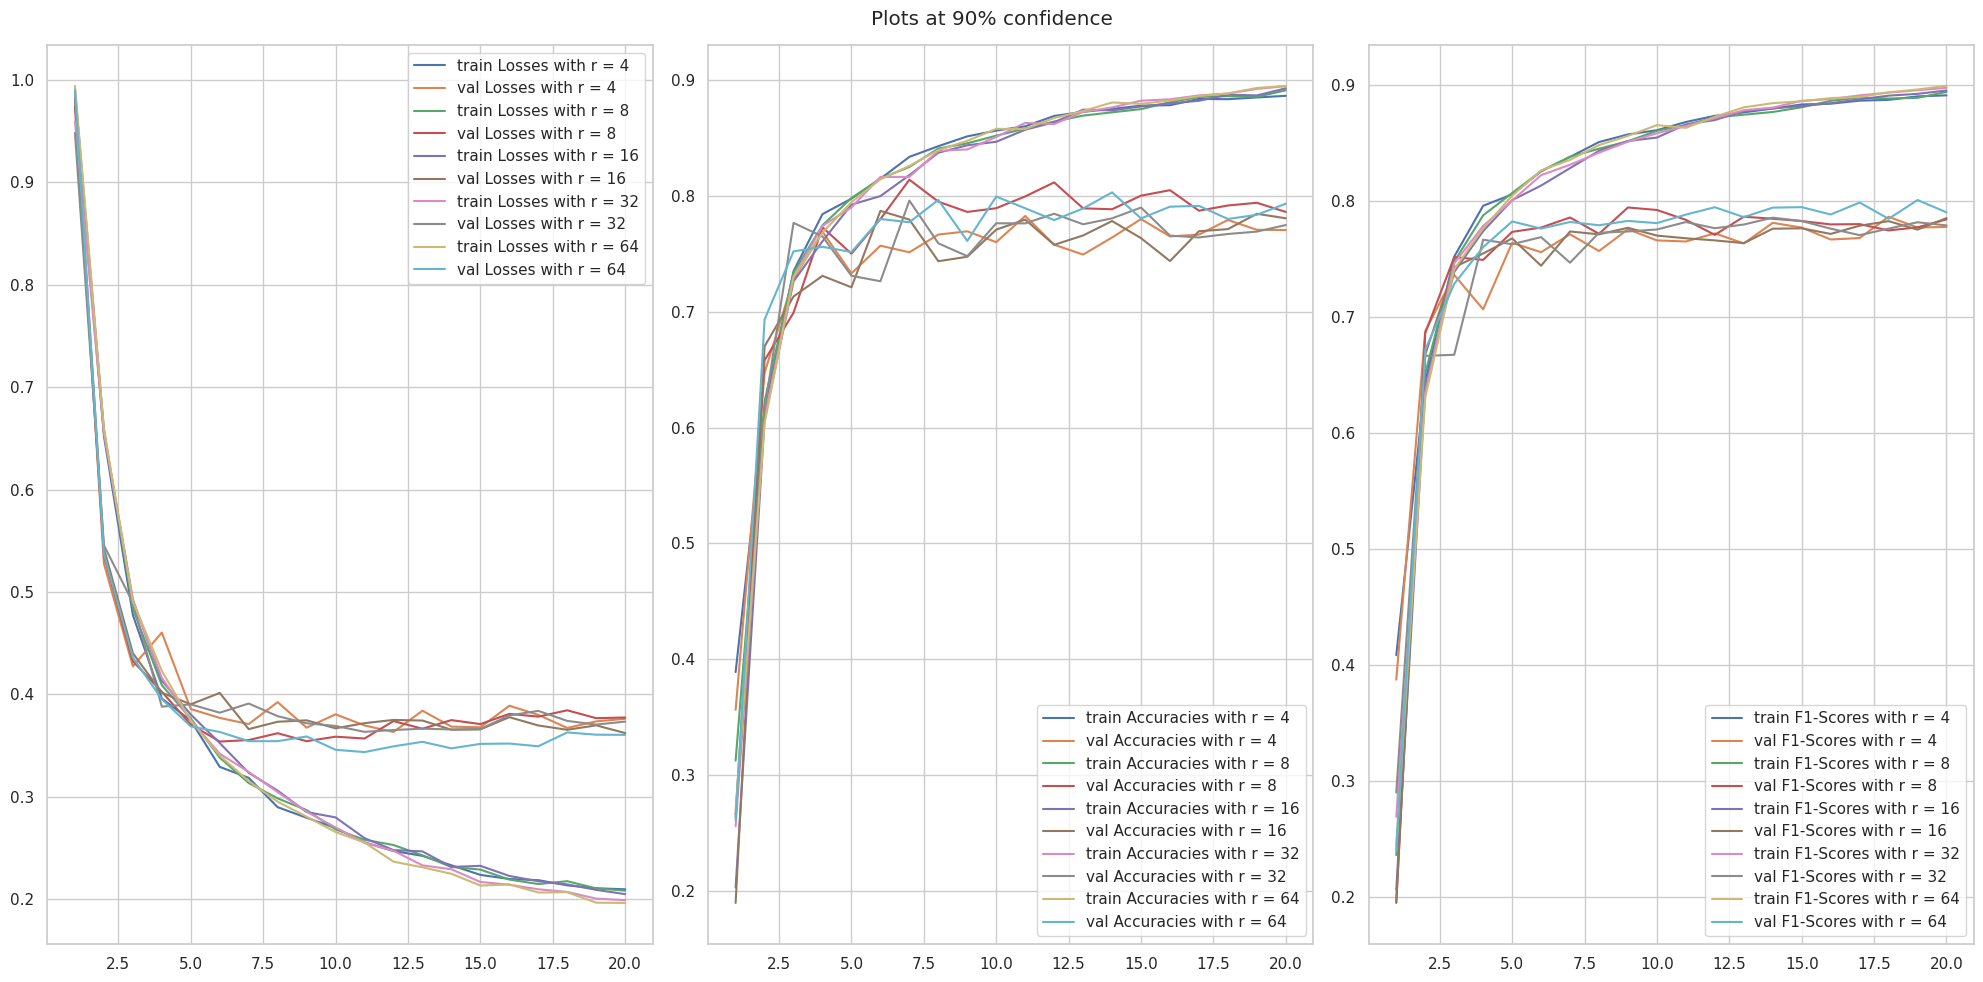

In [61]:
################################    lr=5e-3    ###################################################





sn.set(style="whitegrid")
fig, axs = plt.subplots(1, 3, figsize=(20,10))

plot_data_and_kwargs_loss = []
plot_data_and_kwargs_accs = []
plot_data_and_kwargs_f1s = []

for key in result_dict.keys():

    train_losses_list = [result_dict[key][i]['training_losses_list'][0] for i in range(len(result_dict[key]))]
    train_accs_list = [result_dict[key][i]['training_accs_list'][0] for i in range(len(result_dict[key]))]
    train_f1s_list = [result_dict[key][i]['training_f1s_list'][0] for i in range(len(result_dict[key]))]

    val_losses_list = [result_dict[key][i]['val_losses_list'][0] for i in range(len(result_dict[key]))]
    val_accs_list = [result_dict[key][i]['val_accs_list'][0] for i in range(len(result_dict[key]))]
    val_f1s_list = [result_dict[key][i]['val_f1s_list'][0] for i in range(len(result_dict[key]))]

    # Loss plot
    x_values_loss, mean_curve_loss, ci_lower_loss, ci_upper_loss = aggregate_line_results(train_losses_list)
    plot_data_and_kwargs_loss.append((x_values_loss, mean_curve_loss, ci_lower_loss, ci_upper_loss, f'train Losses with r = {key}'))
    x_values_loss, mean_curve_loss, ci_lower_loss, ci_upper_loss = aggregate_line_results(val_losses_list)
    plot_data_and_kwargs_loss.append((x_values_loss, mean_curve_loss, ci_lower_loss, ci_upper_loss, f'val Losses with r = {key}'))

    # Accuracy plot
    x_values_accs, mean_curve_accs, ci_lower_accs, ci_upper_accs = aggregate_line_results(train_accs_list)
    plot_data_and_kwargs_accs.append((x_values_accs, mean_curve_accs, ci_lower_accs, ci_upper_accs, f'train Accuracies with r = {key}'))
    x_values_accs, mean_curve_accs, ci_lower_accs, ci_upper_accs = aggregate_line_results(val_accs_list)
    plot_data_and_kwargs_accs.append((x_values_accs, mean_curve_accs, ci_lower_accs, ci_upper_accs, f'val Accuracies with r = {key}'))

    # F1-score plot
    x_values_f1s, mean_curve_f1s, ci_lower_f1s, ci_upper_f1s = aggregate_line_results(train_f1s_list)
    plot_data_and_kwargs_f1s.append((x_values_f1s, mean_curve_f1s, ci_lower_f1s, ci_upper_f1s, f'train F1-Scores with r = {key}'))
    x_values_f1s, mean_curve_f1s, ci_lower_f1s, ci_upper_f1s = aggregate_line_results(val_f1s_list)
    plot_data_and_kwargs_f1s.append((x_values_f1s, mean_curve_f1s, ci_lower_f1s, ci_upper_f1s, f'val F1-Scores with r = {key}'))


plot_line_results(axs[0], plot_data_and_kwargs_loss)
plot_line_results(axs[1], plot_data_and_kwargs_accs)
plot_line_results(axs[2], plot_data_and_kwargs_f1s)

fig.suptitle('Plots at 90% confidence')

plt.tight_layout()
plt.show()

In [62]:
data = []
for results in results_dict.values():
    metrics_relaxed_df = results['metrics_words']
    columns = metrics_relaxed_df.mean().index
    values = metrics_relaxed_df.mean().values
    data.append(values)

r_list = list(results_dict.keys())
metrics_recap_df = pd.DataFrame(data=data, index=r_list, columns=columns)

In [63]:
metrics_recap_df

,Precision,Recall,F1
4,0.701875,0.736792,0.711514
8,0.720178,0.718617,0.712500
16,0.709610,0.714434,0.702508
32,0.720677,0.744000,0.722662
64,0.755479,0.725160,0.735384


In [ ]:

def aggregate_metrics_results(metrics_arrays_list, total_reduction: bool = False):
    """
    total_reduction: If for an array of shape (M, N, K) we want the mean to output an array of
        shape (K) and not (N, K) (the mean over all labels instead of label wise in or case)
    """

    if total_reduction:
        axis_kwarg = (0, 1)
    else:
        axis_kwarg = 0
    # Convert the list of arrays to a NumPy array
    arrays_array = np.array(metrics_arrays_list)

    # Calculate the mean and standard deviation
    mean_array = np.mean(arrays_array, axis=axis_kwarg)
    std_dev_array = np.std(arrays_array, axis=axis_kwarg, ddof=1)
    quantile_05 = np.percentile(arrays_array, q=5, axis=axis_kwarg)
    quantile_95 = np.percentile(arrays_array, q=95, axis=axis_kwarg)

    if total_reduction:
        mean_array = mean_array[np.newaxis]
        std_dev_array = std_dev_array[np.newaxis]
        quantile_05 = quantile_05[np.newaxis]
        quantile_95 = quantile_95[np.newaxis]

    new_array = np.empty(mean_array.shape, dtype='U16')
    new_array_min_max = np.empty(mean_array.shape, dtype='U16')

    for i in range(new_array.shape[0]):
        for j in range(new_array.shape[1]):
            # [NOTE]: This is under the assumption that it follows a gaussian distribution
            # new_array[i, j] = str(round(mean_array[i, j], 3)) + ' \u00B1 ' + str(round(1.96 * std_dev_array[i, j], 3))
            # We will rather use the empirical quantiles
            new_array[i, j] = str(round(mean_array[i, j], 3)) + ' \u00B1 ' + str(round((quantile_95[i, j] - quantile_05[i, j]) / 2, 3))
            new_array_min_max[i, j] = '(' + str(round(quantile_05[i, j], 3)) + ' ,' + str(round(quantile_95[i, j], 3)) + ')'

    return new_array, new_array_min_max



In [ ]:

for key_r in result_dict.keys():
    globals()['globals_' + str(key_r)] = pd.DataFrame(data = [['', '', '']], columns=['precision', 'recall', 'f1'], index=[key_r])
    globals()['globals_' + str(key_r) + '_min_max'] = pd.DataFrame(data = [['', '', '']], columns=['precision', 'recall', 'f1'], index=[key_r])
    for key in ['precision', 'recall', 'f1']:
        globals()[f'mean_{key}'] = np.mean([d[key] for d in result_dict[key_r]])
        globals()[f'min_{key}'] = np.min([d[key] for d in result_dict[key_r]])
        globals()[f'max_{key}'] = np.max([d[key] for d in result_dict[key_r]])
        globals()['globals_' + str(key_r)].loc[key_r, key] = globals()[f'mean_{key}']
        globals()['globals_' + str(key_r) + '_min_max'].loc[key_r, key] = (globals()[f'min_{key}'], globals()[f'max_{key}'])
    #globals()['globals_' + key] = pd.concat([globals()['globals_' + key], globals()['globals_' + key + '_' + str(key_r)]])
    #globals()['globals_' + key + '_min_max'] = pd.concat([globals()['globals_' + key + '_min_max'], globals()['globals_' + key + '_' + str(key_r) + '_min_max']])

In [ ]:
pd.concat([globals()[f'globals_{key_r}'] for key_r in result_dict.keys()])
